# Utils

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Paths
path_labels = '/kaggle/input/fcmaps-metadata/labels.csv'
path_fcmaps = '/kaggle/input/fcmaps-processed'                   
path_fcmaps_augmented = '/kaggle/input/fcmaps-augmented-processed/FCmaps_augmented_processed'

# Load labels
df_labels = pd.read_csv(path_labels)

# Temporary:
to_exclude = ['3_S_5003', '4_S_5003', '4_S_5005', '4_S_5007', '4_S_5008']
df_labels = df_labels[~df_labels['ID'].isin(to_exclude)].reset_index(drop=True)

In [3]:
# Parameters
batch_size = 16
epochs = 10
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task = 'classification'               # or 'regression'
n_folds = 10

if task == 'classification':
    criterion = nn.CrossEntropyLoss()
    n_classes = 2  
    label_column = 'Group'
else:
    criterion = nn.MSELoss()
    n_classes = 1
    #label_column = 'Age'

# Dataset

In [4]:
class FCDataset(Dataset):
    def __init__(self, data_dir, df_labels, label_column, task, transform=None):       
        self.data_dir = data_dir
        self.df_labels = df_labels.reset_index(drop=True)
        self.label_column = label_column
        self.task = task
        self.transform = transform
    
        # Dictionary for mapping strings to indices if labels are not numbers
        if not pd.api.types.is_numeric_dtype(self.df_labels[self.label_column]):
            unique_labels = sorted(self.df_labels[self.label_column].unique())
            self.label_mapping = {label: i for i, label in enumerate(unique_labels)}
        else:
            self.label_mapping = None
            
        self.samples = []

        # Loop over each row of the dataframe
        for _, row in self.df_labels.iterrows():
            subj_id = row['ID']
            
            if self.task == 'classification':
                # Classification: map the labels
                label = self.label_mapping[row[self.label_column]]
            
            else:  
                # Regression: convert to float
                label = float(row[self.label_column])

            # Reconstruct the file paths 
            file_path = os.path.join(data_dir, f"{subj_id}.processed.npy")
            if os.path.exists(file_path):
                self.samples.append((file_path, label))
            else:
                print(f"Missing file: {file_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        
        # Load and reshape the volume: (1, 91, 109, 91)
        volume = np.load(file_path)
        volume = np.expand_dims(volume, axis=0)  

        # Covert volume into a tensor
        x = torch.tensor(volume, dtype=torch.float32)

        # Convert the label into a tensor
        if self.task == 'classification':
            y = torch.tensor(label, dtype=torch.long)
        else: 
            y = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            x = self.transform(x)

        return x, y

In [5]:
class AugmentedFCDataset(Dataset):
    def __init__(self, data_dir, df_labels, label_column, task, transform=None):
        
        self.data_dir = data_dir
        self.df_labels = df_labels.reset_index(drop=True)
        self.label_column = label_column
        self.task = task
        self.transform = transform

        # Mapping
        if not pd.api.types.is_numeric_dtype(self.df_labels[self.label_column]):
            unique_labels = sorted(self.df_labels[self.label_column].unique())
            self.label_mapping = {label: i for i, label in enumerate(unique_labels)}
        else:
            self.label_mapping = None
            
        self.samples = []

        for _, row in self.df_labels.iterrows():
            subj_id = row['ID']

            if self.task == 'classification':
                label = self.label_mapping[row[self.label_column]]
            else:
                label = float(row[self.label_column])

            # Loop over each subject folder and list each augmentation
            subject_folder = os.path.join(data_dir, subj_id)
            if os.path.isdir(subject_folder):
                for file in os.listdir(subject_folder):
                    if file.endswith('.npy'):
                        file_path = os.path.join(subject_folder, file)
                        self.samples.append((file_path, label))
            else:
                print(f"Warning: missing augmented folder for subject {subj_id}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load and reshape the volume: (1, 91, 109, 91)
        volume = np.load(file_path)
        volume = np.expand_dims(volume, axis=0)

        x = torch.tensor(volume, dtype=torch.float32)

        if self.task == 'classification':
            y = torch.tensor(label, dtype=torch.long)
        else:
            y = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            x = self.transform(x)

        return x, y

# CNN Models

## Network

In [6]:
from torchvision.models.video import r3d_18

class SimpleCNN3D(nn.Module):
    def __init__(self, n_classes):
        super(SimpleCNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)

        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.AdaptiveAvgPool3d(1)

        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


class ResNet3D(nn.Module):
    def __init__(self, n_classes):
        super(ResNet3D, self).__init__()
        self.model = r3d_18(weights=None)
        self.model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3,7,7), stride=(1,2,2), padding=(1,3,3), bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        return self.model(x)

## Training, Validation and Testing loops

Training function

In [7]:
def train(train_loader, model, criterion, optimizer, device):
    # Enable training mode 
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(x_batch)

        # Compute loss
        loss = criterion(outputs, y_batch)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    return train_loss

Validation function

In [8]:
def validate(val_loader, model, criterion, device, task):
    # Set model to evaluation mode
    model.eval()
    running_loss = 0.0
    correct = 0

    # Disable gradient computation
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            running_loss += loss.item() * x_val.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_val).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)
    return val_loss, val_accuracy

Evaluation function (to get predictions)

In [9]:
def evaluate(model, loader, task, device):
    model.eval()
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            # Convert output to prediction
            if task == 'classification':
                preds = torch.argmax(outputs, dim=1)  
            else:
                preds = outputs.squeeze()  

            # Store true and predicted values
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    return np.array(true_labels), np.array(pred_labels)

# Data

Load some files for example

In [10]:
img3D = np.load('/kaggle/input/fcmaps-processed/002_S_4654.processed.npy')

print(img3D.shape)
print(img3D.dtype)

(91, 109, 91)
float32


## Pairwise classification

- ADNI + CBS = 116 
- CBS + PSP = 105 
- ADNI + PSP = 133

In [11]:
group1 = 'ADNI'
group2 = 'PSP'

df_pair = df_labels[df_labels['Group'].isin([group1, group2])].reset_index(drop=True)

In [12]:
df_pair.shape

(129, 5)

## Splitting

In [13]:
# Splitting of the dataset in training and testing
train_df, df_test = train_test_split(
    df_pair,
    test_size=0.2,
    stratify=df_pair['Group'],
    random_state=42
)

# Splitting of training in training and validation 
df_train, df_val = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df[label_column],
    random_state=42
)

Check the balance between groups

In [14]:
print(df_train['Group'].value_counts())
print(df_val['Group'].value_counts())
print(df_test['Group'].value_counts())

Group
ADNI    45
PSP     37
Name: count, dtype: int64
Group
ADNI    12
PSP      9
Name: count, dtype: int64
Group
ADNI    15
PSP     11
Name: count, dtype: int64


Example of augmentation

In [15]:
train_dataset = AugmentedFCDataset(path_fcmaps_augmented, train_df, label_column, task)

In [16]:
print("Shape before augmentation: ", train_df.shape )
print("Shape after augmentation: ", len(train_dataset) )

Shape before augmentation:  (103, 5)
Shape after augmentation:  1030


# Training

In [17]:
# Create Datasets
train_dataset = AugmentedFCDataset(path_fcmaps_augmented, df_train, label_column, task)
val_dataset = FCDataset(path_fcmaps, df_val, label_column, task)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# MODEL: ResNet3D
model = ResNet3D(n_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Paramters
train_losses = []
val_losses = []
val_accuracies = []

best_accuracy = -float('inf')
best_epoch = -1
best_model_path = None

# Training 
for epoch in range(epochs):
    train_loss = train(train_loader, model, criterion, optimizer, device)
    val_loss, val_accuracy = validate(val_loader, model, criterion, device, task)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save best model with epoch number in the filename
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1  
        best_model_path = f'best_model_epoch{best_epoch}.pt'
        torch.save(model.state_dict(), best_model_path)

Epoch 1/10 | Train Loss: 0.7514 | Val Loss: 1.2130 | Val Accuracy: 0.4286
Epoch 2/10 | Train Loss: 0.6132 | Val Loss: 1.1061 | Val Accuracy: 0.7619
Epoch 3/10 | Train Loss: 0.5406 | Val Loss: 1.3081 | Val Accuracy: 0.6190
Epoch 4/10 | Train Loss: 0.3990 | Val Loss: 3.7803 | Val Accuracy: 0.4762
Epoch 5/10 | Train Loss: 0.3142 | Val Loss: 1.6853 | Val Accuracy: 0.6667
Epoch 6/10 | Train Loss: 0.3042 | Val Loss: 2.2335 | Val Accuracy: 0.7143
Epoch 7/10 | Train Loss: 0.1934 | Val Loss: 1.1448 | Val Accuracy: 0.6667
Epoch 8/10 | Train Loss: 0.1442 | Val Loss: 1.7676 | Val Accuracy: 0.7143
Epoch 9/10 | Train Loss: 0.1870 | Val Loss: 1.3203 | Val Accuracy: 0.7619
Epoch 10/10 | Train Loss: 0.1038 | Val Loss: 2.1942 | Val Accuracy: 0.7619


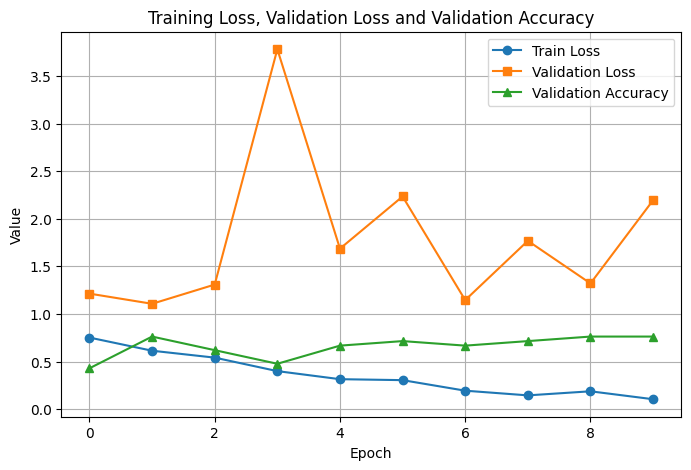

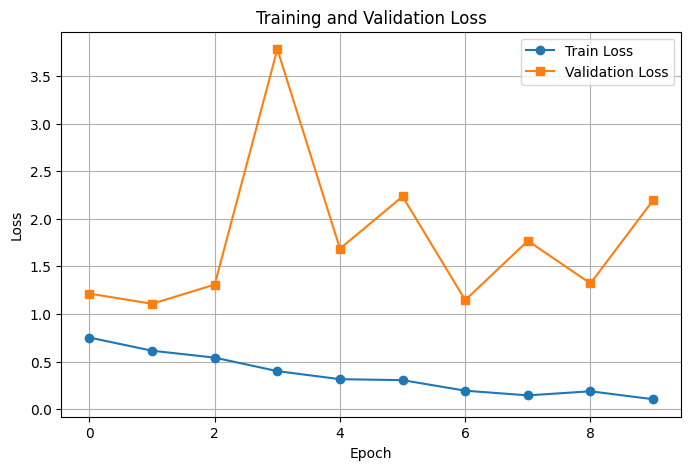

In [18]:
def plot_losses_and_accuracy(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='^')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Loss, Validation Loss and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_losses_only(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- PLOT ---
plot_losses_and_accuracy(train_losses, val_losses, val_accuracies)
plot_losses_only(train_losses, val_losses)

# Evaluation

In [19]:
print(f"\nBest validation accuracy: {best_accuracy:.4f} at epoch {best_epoch}")
print(f"Best model saved at: {best_model_path}")


Best validation accuracy: 0.7619 at epoch 2
Best model saved at: best_model_epoch2.pt


In [20]:
# Dataset and DataLoaders 
test_dataset = FCDataset(path_fcmaps, df_test, label_column, task)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = ResNet3D(n_classes=n_classes).to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Test
y_true, y_pred = evaluate(model, test_loader, task, device)

/tmp/ipykernel_19/3029131000.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


## Classification

In [21]:
# Metrics
report = classification_report(
    y_true, y_pred,
    output_dict=True,
    zero_division=0  
)

df_report = pd.DataFrame(report).transpose()

In [22]:
df_report.round(3)

,precision,recall,f1-score,support
0,0.579,0.733,0.647,15.000
1,0.429,0.273,0.333,11.000
accuracy,0.538,0.538,0.538,0.538
macro avg,0.504,0.503,0.490,26.000
weighted avg,0.515,0.538,0.514,26.000


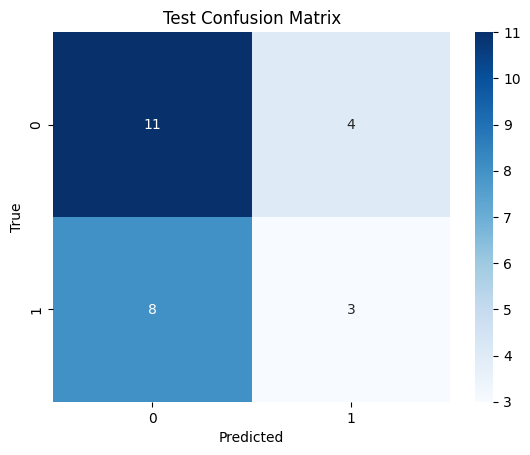

In [23]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()